#Importing relevant libraries

In [258]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense,Dropout

import matplotlib.pyplot as plt

#Setting up the data folder

In [259]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [260]:
os.chdir("/content/drive/My Drive/Mini_Project_2/")
os.getcwd()

'/content/drive/My Drive/Mini_Project_2'

#Reading the data file

In [261]:
df = pd.read_csv("/content/drive/My Drive/Mini_Project_2/LOLC_Historical_Data.csv")
df.head(10)

,Date,Price,Open,High,Low,Vol.,Change %
0,12/29/2023,360.00,359.50,360.00,350.00,35.38K,1.12%
1,12/28/2023,356.00,360.00,360.00,350.00,11.54K,-1.04%
2,12/27/2023,359.75,362.25,364.00,355.75,7.51K,-0.76%
3,12/22/2023,362.50,362.50,365.00,359.50,14.79K,0.14%
4,12/21/2023,362.00,365.00,369.00,362.00,3.37K,-1.09%
5,12/20/2023,366.00,365.00,369.50,362.50,11.76K,0.27%
6,12/19/2023,365.00,368.00,368.25,363.50,5.30K,-1.28%
7,12/18/2023,369.75,372.00,372.00,366.75,5.44K,-0.67%
8,12/15/2023,372.25,370.00,374.00,368.00,7.65K,0.61%
9,12/14/2023,370.00,371.75,371.75,369.75,14.74K,1.09%


#Preprocessing the data

In [262]:
#Converting 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

# Removing non-numeric characters and convert numerical columns to float
for col in df.columns[1:]:
    df[col] = df[col].str.replace(r'[^\d.]', '', regex=True).astype(float)

#handling missing values
print("Missing values before handling:")
print(df.isnull().sum())

# Drop rows with missing values
df.dropna(inplace=True)

#Normalizing the numerical data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.drop(columns='Date'))

# Creating time series data with three-day windows
lookback = 3
generator = TimeseriesGenerator(scaled_data, scaled_data, length=lookback, batch_size=1)

# Split the data into training and testing sets (80-20 % split)
train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]


Missing values before handling:
Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64


#Creating sequences

In [263]:
#for LSTM model
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:(i + lookback), 0])
        y.append(data[i + lookback, 0])
    return np.array(X), np.array(y)

#for training and testing data
X_train, y_train = create_sequences(train, lookback)
X_test, y_test = create_sequences(test, lookback)

#Reshaping the data for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#Constructing the LSTM model

In [264]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1))

#Training the model

In [265]:
model.compile(loss='mean_squared_error', optimizer='adam')
hist = model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=1)

Epoch 1/10
1109/1109 [==============================] - 15s 8ms/step - loss: 0.0024
Epoch 2/10
1109/1109 [==============================] - 8s 7ms/step - loss: 0.0013
Epoch 3/10
1109/1109 [==============================] - 7s 6ms/step - loss: 0.0013
Epoch 4/10
1109/1109 [==============================] - 8s 7ms/step - loss: 0.0011
Epoch 5/10
1109/1109 [==============================] - 6s 6ms/step - loss: 9.6001e-04
Epoch 6/10
1109/1109 [==============================] - 8s 7ms/step - loss: 8.5148e-04
Epoch 7/10
1109/1109 [==============================] - 7s 6ms/step - loss: 7.8703e-04
Epoch 8/10
1109/1109 [==============================] - 8s 7ms/step - loss: 9.9479e-04
Epoch 9/10
1109/1109 [==============================] - 8s 7ms/step - loss: 7.3179e-04
Epoch 10/10
1109/1109 [==============================] - 8s 7ms/step - loss: 8.1557e-04


#Predicting stock prices for test data

In [266]:
Y_predictions = model.predict(X_test)
# Reshape Y_predictions to match the shape of X_train
Y_predictions = Y_predictions.reshape(-1, 1)


9/9 [==============================] - 1s 8ms/step


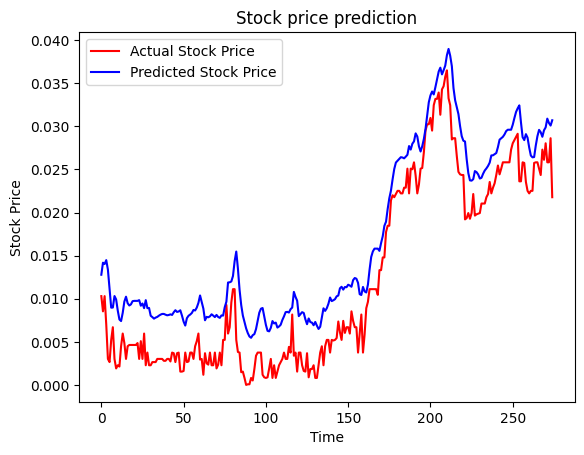

In [267]:
plt.plot(y_test, color = 'red', label = 'Actual Stock Price')
plt.plot(Y_predictions, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock price prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

#Calculating RMSE

In [268]:
rmse = np.sqrt(np.mean(((Y_predictions - y_test) ** 2)))
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 0.01522175573339386
